<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/2_RedesDeUnaCapa/2_clasificacion_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Regresión Softmax

Al igual que dijimos antes, esperamos que al llegar aquí sepas que es una regresión logística. Esto es porque una regresión softmax es la generalización de la regresión logística, pero para muchas clases, en lugar de solo una.

Una regresión logística es una técnica de apendizaje automático para clasificación binaria. En este típo de problemas hay solo dos resultados. Por ejemplo, podríamos estar interesados en tratar de predecir si una persona tiene una determinada enfermedad. Así por ejemplo podríamos considerar una serie de datos como los siguientes:

||temperatura|oxigenación|decaimiento|dolores|bultos en pulmones|presenta enfermedad|
|---|:-:|:-:|:-:|:-:|:-:|:-:|
|paciente 1| 36.7| 0.88| 0|1|1|1|
|paciente 2| 38.0| 0.98| 1|0|0|0|

Hasta aquí, esto parece una regresión lineal como lo vimos antes. Tenemos nuestras variables y nuestra repuesta esperada. Presentamos una matriz de diseño, una serie de valores reales o **grounding truth**, tenemos parametros de nuestro modelo...

$$\begin{align}
     X = \left[\begin{array}{ccccc}
      36.7& 0.88& 0&1&1\\
      38.0& 0.98& 1&0&0
     \end{array}\right]~ y = \left[\begin{array}{c}
      1\\
      0
     \end{array}\right]
     \end{align}
$$

Sin embargo, la mayor diferencia es que en una regresión logística lo que queremos es un probabilidad de estar enfermo. Eso hace que no podamos usar la regresión lineal para este problema. Además, dado que necesitamos una salida que sea una probabilidad, necesitamos entregar un valor entre 1 y 0.

Es por esto que en regresión logística el modelo tiene otra forma:

$$\hat{y} = \sigma\left(Xw + b\right)$$

Donde $\hat{y}$ es nuestra predicción, $w$ nuestros parametros y $b$ nuestro bias. La principal diferencia es que ahora a nuestro valor los metemos adentro de una función llamada sigmodea:

$$\sigma(x) = \dfrac{1}{1 + e^{-x}}$$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png)

Esta función es la que ahora nos asegura que nuestra prediccion sea una probabilidad.

La otra diferencia es que ahora, para encontrar los los parametros no usaremos mínimos cuadrados, sino otra herramienta. Pero esto lo explicaremos más adelante.

Dijimos que una regresión lineal era una neurona

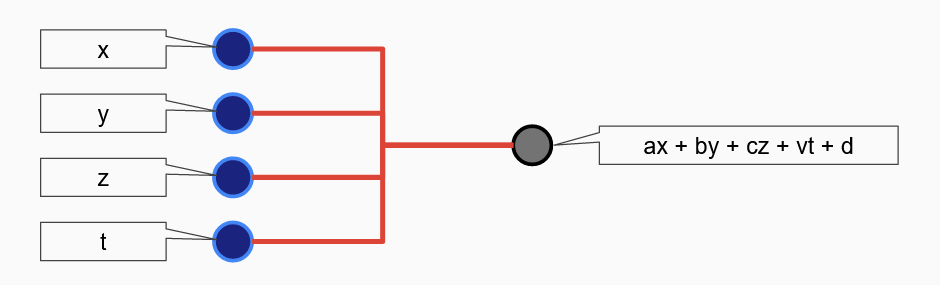

Ahora, ¿podemos decir que una regresión logística es una neurona?

En principio, la única diferencia es que a la salida del modelo lineal, agregamos una función adicional. De esta manera, podemos pensar una regresión logística como un tipo especial de neurona.

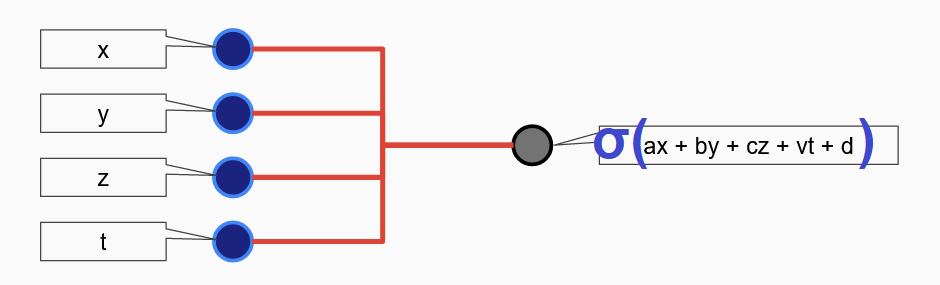



Hasta recien trabajamos con dos clases. Esto era proque la regresión lógistica solo nos permite trabajar con dos clases. Si trabajaramos con varias clases, ¿podríamos seguir pensando en que esto es una neurona o una red neuronal?

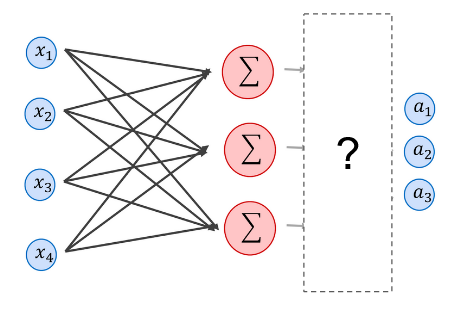

En breve veremos que sí es posible, pero para esto vamos a usar otra función distinta a la sigmoidea. Esta función, llamada **Softmax**, nos entregará un vector numérico. Cada componente del vector corresponde a la probabilidad de que nuestro ejemplo corresponde a cada clase.

## Presentando el problema

Al igual que en el caso anterior, primero haremos una implementación desde 0 y luego una implementación usando las herrameintas de nuestro framework. Como dijimos, nuestro objetivo con esto es  a perderle el miedo a los frameworks. 

Hemos elegido un dataset preexistente conocido como FashionMNIST

Estos datos son imágenes de $28 × 28 $ píxeles de indumentaria. Cada imagen tiene asociada una clase. En total hay 10 clases

Nuestra propuesta de clasificador consistira en tomar los valores de los píxeles, tratarlos como vectores y multiplicarlos por los pesos correspondiente para obtener un conjunto de valores. Esos valores serán la probabilidad de que pertenezcan a cada una de las clases definidas en nuestros datos.

In [ ]:
import torch
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

In [ ]:
# Ejemplo de dataloader para Fashion MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)



Como estamos trabajando con imágenes, en este caso nuestros features son los valores de cada píxel. Cada imagen es de  $28 \times 28$ píxeles, por lo que en total tenemos $784$ features. Por otro lado, estás imágenes de indumentaria tienen etiquetas correspondientes a $10$ clases en total. Esto significa que nuestra matriz de pesos ahora tendra  un tamaño de $784 \times 10$


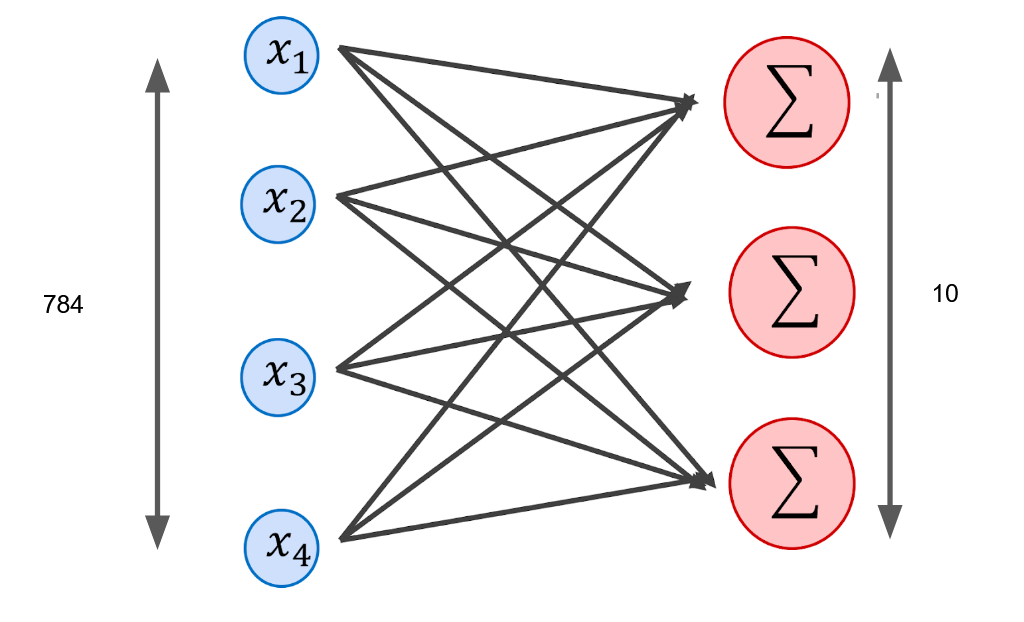

Dicho de otro modo. Vamos a necesitar 10 neuronas que miren nuestros píxeles y a partir de los que vean traten de devolvernos valores que de alguna manera luego transformaremos en probabilidades. Es decir, vamos a trabajar con una capa de neuronas y no con una única neurona.

Con esto hemos definido los pesos de la parte lineal de nuestro modelo, ahora necesitamos definir alguna función que nos permita convertir nuestras salidas en probabilidades. Además esta función debe ser análoga a lo que hacía la sigmoidea en la regresión logística. 

La función que usamos para esto es la función softmax:

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{a})\quad \text{y}\quad \hat{y}_j = \frac{\exp(a_j)}{\sum_k \exp(a_k)}. $$

Softmax, nos devuelve un vector $\hat{y}$. Se puede ver que, para la definición componente a componente la suma de los $\hat{y_j}$ es $1$.  Además $\hat{y_j}$ nunca es negativo. Es decir, describen un vector de probabilidades. Si lo entrenamos correctamente $\hat{y_j}$ nos dice que tan probable es que nuestro ejemplo pertenezca a la clase $j$.

Se puede demostrar que Softmax para dos clases recupera el comportamiento de la sigmoidea. En este sentido es una generalización de la clasificación logística. 

## Definiendo softmax

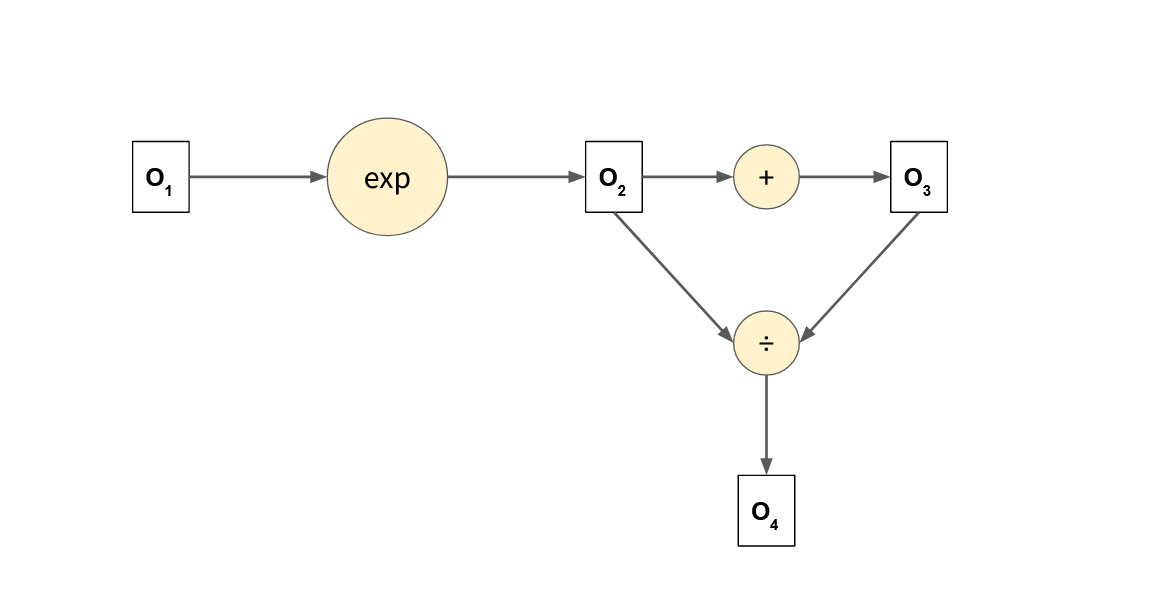

$$ \hat{y}_j = \frac{\exp(a_j)}{\sum_k \exp(a_k)}. $$

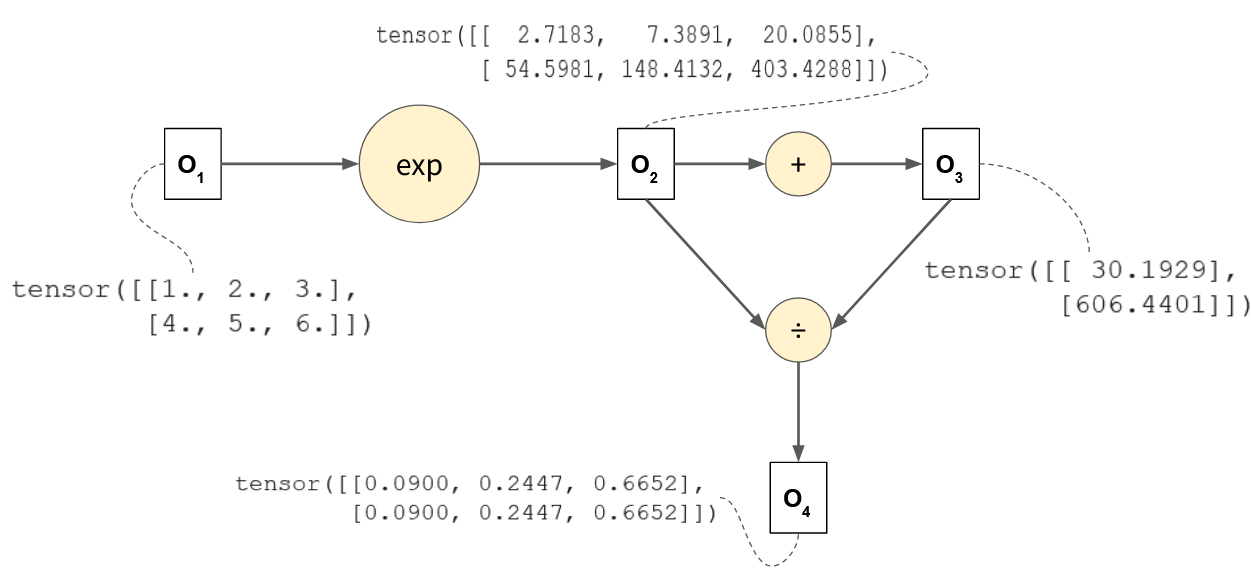

$$ \hat{y}_j = \frac{\exp(a_j)}{\sum_k \exp(a_k)}. $$

Las figuras anteriores muestran como es el proceso de cálculo de Softmax:

1. aplicamos exponencial a cada salida de nuestras estimaciones (de $O_1$ a $O_2$)
2. sumamos para cada ejemplo (representado en la fila) (de $O_2$ a $O_3$)
3. dividimos el valor obtenido en 2 para cada ejemplo con cada esimación (flechas desde $O_2$ y $O_3$ a $O_4$)

## Inicialización de parámetros.

In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

print(W.shape)
print(b.shape)

torch.Size([784, 10])
torch.Size([10])


## Definiendo softmax


In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# señalar la diferencia en la suma
X.sum(0, keepdim=True), X.sum(1, keepdim=True) 

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # broadcasting

In [ ]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0820, 0.3186, 0.1591, 0.3522, 0.0881],
         [0.0437, 0.1855, 0.4383, 0.0993, 0.2331]]), tensor([1., 1.]))

Esta implementación no es perfecta, y de hecho puede generar problemas numéricos.

Para más información referimos a [link](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).

## Definiendo el modelo.

A continuación mostramos como se ve nuestro modelo luego de aplicar las sucesivas operaciones.

¿Entiende porque es que `reshape` tiene las entradas que aparecen? 


In [ ]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

La función `reshape` en el fondo lo que hace es convertir nuestros datos de un conjunto de matrices, a un conjunto de vectores 

## Definiendo la función de pérdida

Al igual que con la regresión logística, la función de pérdida a minimizar es la entropía cruzada. La entropía cruzada tiene la propiedad de que su gradiente es la función Softmax. Por esto también es una función muy muy útil

$$\text{CEntropy}(\mathbf{y},\mathbf{\hat{y}}) = \sum_{i \in \text{clases}} y_i \ln \hat{y}_i$$

A continuación discutiremos la utilidad la noción de entropía en estadística y su relación con la noción de información.

## Entropía e información

A continuación proponemos un un juego para dos jugadores:

* Materiales:
  * una bolsa o recipiente opaco
  * 4 pelotas con los números 1, 2, 3, 4
* Preparativos:
  * Se colocan las pelotas en la bolsa 
  * El primer jugador saca una de las pelotas de la bolsa
* Objetivo general: Adivinar con el menor número de preguntas posibles cuál el número de la pelota que tiene el primer jugador .
  * Solo pueden hacerse preguntas que tengan como respuestas sí o no.

No es dificil ver que este juego tiene la siguiente estrategia optima:

```
1. Preguntar: "¿El número es par?"
  A. Si la respuesta es sí, preguntar: "¿Es el número 4?"
    a. Si la respuesta es sí, sabemos que es el número 4, hemos ganado.
    b. Si la respuesta es no, sabemos que es el número 2, hemos ganado.
  B. Si la respuesta es no, preguntar: "¿Es el número 3?"
    a. Si la respuesta es sí, sabemos que es el número 3, hemos ganado.
    b. Si la respuesta es no, sabemos que es el número 1, hemos ganado.
```

En este juego, es fácil ver que está solución es optima porque solo hay una copia de cada pelota. Dicho de otro modo, nuestra estrategia podría cambiar si dentro de la bolsa, hubieran otras pelotas o si las distribución de las pelotas cambiara.

El punto central de este ejercicio es que para este caso de 4 categorías **equiprobables** necesitamos 2 preguntas. 

Veamos esto:

||$1$|$2$|$3$|$4$|total|
|---|---|---|---|---|:-:|
|probabilidad de ocurrir|$\dfrac{1}{4}$|$\dfrac{1}{4}$|$\dfrac{1}{4}$|$\dfrac{1}{4}$|-|
|número de preguntas|$2$|$2$|$2$|$2$|-|
|producto|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$2$|

Cambiemos ahora nuestro juego de la siguiente manera:

* Materiales:
  * 8 pelotas con los números 1, 1, 1, 1, 2, 2, 3, 4

El hecho de que ahora cambiemos nuestra distribución de pelotas, hace que ahora la estrategia optima cambie:

```
1. Preguntar: "¿Es el número 1?"
  A. Si la respuesta es sí, hemos ganado."
  B. Si la respuesta es no, preguntar: "¿Es el número 2?"
    a. Si la respuesta es sí, hemos ganado.
    b. Si la respuesta es no, preguntar: "¿Es el número 3?.
      I. Si la respuesta es sí, sabemos que es el número 3, hemos ganado.
      I. Si la respuesta es no, sabemos que es el número 4, hemos ganado.
```

||$1$|$2$|$3$|$4$|total|
|---|---|---|---|---|:-:|
|probabilidad de ocurrir|$\dfrac{4}{8}$|$\dfrac{2}{8}$|$\dfrac{1}{8}$|$\dfrac{1}{8}$|-|
|número de preguntas|$1$|$2$|$3$|$3$|-|
|producto|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$\dfrac{3}{8}$|$\dfrac{3}{8}$|$1.75$|


El lector perpicaz debería notar las siguientes cosas:

1. Lo que hemos hecho es exactamente lo mismo que uno hace cuando analiza algo con árboles de deciciones
2. El número de preguntas se corresponde a la entropía estadística de la distribución
$$H = -\sum_{i\in \text{clases}}P(i)\log_2 P(i)$$
2. El resultado que hemos obtenido es similar a encontrar un código de Huffman para la pelotas

Es esta relación entre número de preguntas y distribuciones lo que da lugar a la noción de entropía dentro de la teoría de la información de Shannon

### Entropía cruzada

Ahora, la siguiente pregunta que nos podemos hacer es que pasaría si uno de los jugadores del primer juego, tratara de jugar el segundo. Es decir, ¿que pasa si usamos la estrategia optima del primer juego en el segundo juego? Lo que hay que ver es que en este paso usaremos el número de preguntas del primer juego con la probabilidad del segundo.


||$1$|$2$|$3$|$4$|total|
|---|---|---|---|---|:-:|
|probabilidad de ocurrir|$\dfrac{4}{8}$|$\dfrac{2}{8}$|$\dfrac{1}{8}$|$\dfrac{1}{8}$|-|
|número de preguntas|$2$|$2$|$2$|$2$|-|
|producto|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$\dfrac{1}{2}$|$2$|


El número promedio de preguntas ha aumentado. 

Esto último puede parecer un mero ejercicio teórico, pero en realidad nos está diciendo mucho. En general cuando clasificamos, no conocemos las distribución real de las clases de nuestro problema. Del mismo modo, nuestro clasificador, implicitamente supone una distribución probabilistica (asociada a nuestra muestra). Es decir estamos en una situación donde creemos que estamos en un juego como el primero, pero podríamos estar un juego como el segundo. Es en este sentido que tiene sentido calcular la entropia a partir de dos distribuciones distintas. La de nuestro clasificador y la de nuestros datos. Esto es lo que minimizamos con la entropía cruzada: Dado nuestro modelo, que tan bueno es reproduciendo los valores reales.

$$CE(P,Q) = -\sum_{i\in \text{clases}}P(i)\ln Q(i)$$

$Q$ es la distribución probabilística de nuestro modelo, $P$, la de nuestros datos

En este último caso pusimos el logaritmo neperiano en lugar del logaritmo de base 2. Esto en el fondo es irrelevante, la fórmula del cambio de base, no dice que esto solo afecta en una contante multiplicativa. Por lo tanto, nuestro mínimo sera el mismo.

$$\log_b x=\dfrac{\ln x}{\ln b}$$

## Implementación de la Entropía Cruzada

$$\text{CEntropy}(\mathbf{y},\mathbf{\hat{y}}) = \sum_{i \in \text{clases}} y_i \ln \hat{y}_i$$

Por la forma que tienen nuestros datos, es posible usar una serie de trucos para calcular más rápidamente la entropia cruzada.

Es facil ver que como estamos usando one-hot vectors, $y_i$ solo vale $1$ para la clase correcta o $0$ para las demás. Por lo tanto solo debemos calcular el logaritmo para la clase correcta. 

In [ ]:
y = torch.tensor([0, 2]) #etiquetas

# estimaciones con softmax
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) 

y_hat[[0, 1], y]
## y_hat[[0, 1], y]
#      del ejemplo 0, obtenemos el indice 0
#      del ejemplo 1, obtenemos el indice 2

tensor([0.1000, 0.5000])

In [ ]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## Accuracy

Por lo general tomamos al valor más alto de las probabilidades como el valor correcto. Al trabajar de esta manera debemos tratar de ver cuantas veces acertamos en nuestras predicciones. Para ellos definimos el Accuracy

In [ ]:
y_hat.argmax(axis=1)

tensor([2, 2])

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
accuracy(y_hat, y) / len(y)

0.5

## Definiendo el algoritmo de optimización

Tomamos el mismo código de sgd discutido antes.

In [ ]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Entrenamiento


In [ ]:
num_epochs = 10
loss = cross_entropy
trainer = sgd
lr = 0.1
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        l.sum().backward()
        trainer([W, b], lr, batch_size)
        L += l.sum()
        N += l.numel()
        Acc += accuracy(net(X), y)
    for X, y in test_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 0.785733          , train accuracy  0.766867, test accuracy 0.793600
epoch 2, loss 0.570295          , train accuracy  0.822583, test accuracy 0.805500
epoch 3, loss 0.525072          , train accuracy  0.833183, test accuracy 0.819000
epoch 4, loss 0.501042          , train accuracy  0.839400, test accuracy 0.823600
epoch 5, loss 0.485246          , train accuracy  0.843583, test accuracy 0.828500
epoch 6, loss 0.474382          , train accuracy  0.846217, test accuracy 0.827900
epoch 7, loss 0.465548          , train accuracy  0.849767, test accuracy 0.828200
epoch 8, loss 0.457960          , train accuracy  0.852333, test accuracy 0.831400
epoch 9, loss 0.452361          , train accuracy  0.853167, test accuracy 0.834400
epoch 10, loss 0.447754          , train accuracy  0.854417, test accuracy 0.833800


Ahora, analicemos como haríamos esto usando la las herramientas de nuestro framework

# Regresión Softmax concisa


Por ahora la mayor parte del código que revisaremos es casi identico a lo que ya conocemos.

In [ ]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

In [ ]:
#Ejemplo de dataloader para Fashion MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## Inicialización.


In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

¿Qué hace Flatten?

Convierte la matriz de píxeles a un vector de números.

## Softmax 

Dijimos anterioremente que nuestre primera implementación de Softmax era inestable computacionalmente. Por esta razón, los frameworks preexistentes hacen uso de otras implementaciones que evitan estas inestabilidades. Para más información, dejamos el siguiente link

["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).


In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

## Algoritmo de optimización.


In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

## Entrenamiento

In [ ]:
num_epochs = 10
lr = 0.01
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(net(X), y)
    for X, y in train_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 0.785447          , train accuracy  0.765183, test accuracy 0.797900
epoch 2, loss 0.569927          , train accuracy  0.822217, test accuracy 0.803367
epoch 3, loss 0.525173          , train accuracy  0.832900, test accuracy 0.822733
epoch 4, loss 0.501484          , train accuracy  0.838333, test accuracy 0.834483
epoch 5, loss 0.484842          , train accuracy  0.844067, test accuracy 0.840733
epoch 6, loss 0.473560          , train accuracy  0.847100, test accuracy 0.829883
epoch 7, loss 0.465181          , train accuracy  0.849417, test accuracy 0.846683
epoch 8, loss 0.457277          , train accuracy  0.851317, test accuracy 0.840217
epoch 9, loss 0.452576          , train accuracy  0.852650, test accuracy 0.843150
epoch 10, loss 0.447156          , train accuracy  0.854250, test accuracy 0.845883


Como vemos, no hay mucho más que discutir y analizar. 